In [4]:
import pandas as pd

def preprocess_data(csv_file):
    df = pd.read_csv(csv_file)
    
    # Convert data to transactional format
    transactions = []
    for index, row in df.iterrows():
        transaction = [col for col in df.columns[1:] if row[col] == 1]
        transactions.append(transaction)
    
    # Optionally, add disease name to each transaction for clarity
    diseases = df.iloc[:, 0].tolist()
    transactions_with_disease = list(zip(diseases, transactions))
    
    # Convert transactions to a binary format suitable for FP-Growth
    binary_transactions = []
    for transaction in transactions:
        binary_row = [1 if symptom in transaction else 0 for symptom in df.columns[1:]]
        binary_transactions.append(binary_row)
    
    return df, transactions_with_disease, binary_transactions

In [ ]:
# sample_size = 0.01
# full_df = pd.read_csv(csv_file)
# sampled_df = full_df.sample(frac=sample_size, random_state=42)
# temp_csv = './data/small_sample.csv'
# sampled_df.to_csv(temp_csv, index=False)
csv_file = './data/augmented_dataset.csv'
df, transactions_with_disease, binary_transactions = preprocess_data(csv_file)

In [6]:
# Print results
print("Original DataFrame:")
print(df.head())
print("\nTransactions with Disease:")
print(transactions_with_disease[:5])
print("\nBinary Transactions:")
print(binary_transactions[:5])

Original DataFrame:
                       diseases  anxiety and nervousness  depression  \
0                     psoriasis                        0           0   
1                  food allergy                        0           0   
2  fungal infection of the hair                        0           0   
3          threatened pregnancy                        0           0   
4            intestinal disease                        0           0   

   shortness of breath  depressive or psychotic symptoms  sharp chest pain  \
0                    0                                 0                 0   
1                    0                                 0                 0   
2                    0                                 0                 0   
3                    0                                 0                 0   
4                    0                                 0                 0   

   dizziness  insomnia  abnormal involuntary movements  chest tightness  ...  

In [7]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [8]:
binary_df = pd.DataFrame(binary_transactions, columns=df.columns[1:])
binary_df = binary_df.astype(bool)

# Generate frequent itemsets using FP-Growth
# Adjust `min_support` based on your requirements (e.g., 0.001 for low threshold)
frequent_itemsets = fpgrowth(binary_df, min_support=0.0005, use_colnames=True)

KeyboardInterrupt: 

In [193]:
def save_to_csv(rules, filename="association_rules.csv"):
    try:
        # Convert the list of Series to a DataFrame
        rules_df = pd.DataFrame(rules)

        # Save the DataFrame to a CSV file
        rules_df.to_csv(filename, index=False)

        print(f"Association rules saved to {filename}")

    except Exception as e:
        print(f"Error saving association rules to CSV: {e}")

In [ ]:
print("Frequent Itemsets:")
print(frequent_itemsets)
frequent_itemsets_df = pd.DataFrame(frequent_itemsets)
filename = "frequent_itemsets.csv"
frequent_itemsets_df.to_csv(filename, index=False)
print(f"Frequent itemsets saved to {filename}")

Frequent Itemsets:
        support                                           itemsets
0      0.131042                             (sharp abdominal pain)
1      0.042526                                        (side pain)
2      0.038204                                      (pelvic pain)
3      0.035055                                (painful urination)
4      0.033586                               (retention of urine)
...         ...                                                ...
26505  0.000501       (abdominal distention, upper abdominal pain)
26506  0.000570             (vomiting blood, abdominal distention)
26507  0.000647  (hand or finger stiffness or tightness, should...
26508  0.000523  (muscle stiffness or tightness, difficulty spe...
26509  0.000504                    (emotional symptoms, dizziness)

[26510 rows x 2 columns]
Association rules saved to frequent_itemsets.csv


In [ ]:
# Generate association rules from frequent itemsets
# Adjust `min_threshold` for confidence based on your requirements
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'leverage', 'lift']]

In [ ]:
# Display association rules
print("Association Rules:")
print(rules)  
rules_df = pd.DataFrame(rules)
filename = "association_rules.csv"
rules_df.to_csv(filename, index=False)
print(f"Association rules saved to {filename}")

Association Rules:
                                    antecedents  \
0                        (sharp abdominal pain)   
1                                   (side pain)   
2                                   (side pain)   
3                                   (back pain)   
4                        (lower abdominal pain)   
...                                         ...   
218733  (hand or finger stiffness or tightness)   
218734                      (shoulder weakness)   
218735          (muscle stiffness or tightness)   
218736                    (difficulty speaking)   
218737                     (emotional symptoms)   

                                    consequents   support  confidence  \
0                                   (side pain)  0.017135    0.130757   
1                        (sharp abdominal pain)  0.017135    0.402927   
2                                   (back pain)  0.015716    0.369566   
3                                   (side pain)  0.015716    0.178162   
4  

In [219]:
# high_support_threshold = 0.02
# high_confidence_threshold = 0.25

# low_support_threshold = 0.005
# low_confidence_threshold = 0.05

high_support_threshold = 0.01
high_confidence_threshold = 0.25

low_support_threshold = 0.002
low_confidence_threshold = 0.05

In [220]:
significant_rules = rules[
    (rules['support'] >= high_support_threshold) &
    (rules['confidence'] >= high_confidence_threshold) &
    (rules['lift'] > 1.5)
]

# Filter semi-significant rules
semi_significant_rules = rules[
    (rules['support'] >= low_support_threshold) &
    (rules['confidence'] >= low_confidence_threshold) &
    (rules['lift'] > 2.0) &
    ~((rules['support'] >= high_support_threshold) &
      (rules['confidence'] >= high_confidence_threshold) &
      (rules['lift'] > 5.0))
]

In [221]:
# Sort rules by a combined metric and take top 1000
rules['combined_score'] = rules['support'] * rules['confidence'] * rules['lift'] 
top_rules = rules.sort_values('combined_score', ascending=False).head(1000)

print(top_rules)

                                              antecedents  \
207284                                    (regurgitation)   
207285                                  (regurgitation.1)   
208136                 (suprapubic pain, regurgitation.1)   
208134                   (regurgitation, suprapubic pain)   
207807              (sharp abdominal pain, regurgitation)   
...                                                   ...   
207440  (burning abdominal pain, sharp abdominal pain,...   
154010  (symptoms of the scrotum and testes, pain in t...   
162804           (sharp chest pain, increased heart rate)   
173471                          (toothache, jaw swelling)   
144172                                   (elbow swelling)   

                                 consequents   support  confidence  leverage  \
207284                     (regurgitation.1)  0.010047    1.000000  0.009878   
207285                       (regurgitation)  0.010047    0.596466  0.009878   
208136    (regurgitation, p

In [222]:
print("Significant Rules: "+ str(len(significant_rules)))
print(significant_rules)

print("\nSemi-Significant Rules: " + str(len(semi_significant_rules)))
print(semi_significant_rules)

Significant Rules: 279
                            antecedents                      consequents  \
1                           (side pain)           (sharp abdominal pain)   
2                           (side pain)                      (back pain)   
7                           (side pain)                         (nausea)   
11                          (side pain)                       (vomiting)   
1228                      (pelvic pain)           (sharp abdominal pain)   
...                                 ...                              ...   
193727  (foreign body sensation in eye)                    (pain in eye)   
193728                (symptoms of eye)  (foreign body sensation in eye)   
193729  (foreign body sensation in eye)                (symptoms of eye)   
207284                  (regurgitation)                (regurgitation.1)   
207285                (regurgitation.1)                  (regurgitation)   

         support  confidence  leverage       lift  
1       0.01

In [223]:
from collections import defaultdict

def calculate_symptom_cooccurrence(transactions_with_disease):
    cooccurrence_matrix = defaultdict(lambda: defaultdict(int))
    for disease, symptoms in transactions_with_disease:
        for i, symptom1 in enumerate(symptoms):
            for symptom2 in symptoms[i+1:]:
                cooccurrence_matrix[symptom1][symptom2] += 1
                cooccurrence_matrix[symptom2][symptom1] += 1
    return cooccurrence_matrix

In [224]:
def cluster_rules_by_cooccurrence(significant_rules, semi_significant_rules, cooccurrence_matrix, threshold=1):
    clustered_rules = defaultdict(list)

    all_rules = pd.concat([significant_rules, semi_significant_rules], ignore_index=True)

    for index, rule in all_rules.iterrows():
        antecedents = list(rule['antecedents'])
        cluster_key = tuple(sorted(antecedents))  # Use sorted tuple as cluster key

        # Check if any existing cluster has significant co-occurrence
        added_to_cluster = False
        for existing_cluster_key, existing_rules in clustered_rules.items():
            existing_antecedents = list(existing_cluster_key)
            # Calculate co-occurrence score between the current rule and existing cluster
            cooccurrence_score = 0
            for symptom1 in antecedents:
                for symptom2 in existing_antecedents:
                    cooccurrence_score += cooccurrence_matrix[symptom1][symptom2]

            if cooccurrence_score >= threshold:
                clustered_rules[existing_cluster_key].append(rule)
                added_to_cluster = True
                break

        # If no suitable cluster found, create a new cluster
        if not added_to_cluster:
            clustered_rules[cluster_key].append(rule)

    return clustered_rules

In [225]:
cooccurrence_matrix = calculate_symptom_cooccurrence(transactions_with_disease)
clustered_rules = cluster_rules_by_cooccurrence(significant_rules, semi_significant_rules, cooccurrence_matrix)

In [226]:
num_clusters = len(clustered_rules)
print(f"Number of clusters generated: {num_clusters}")

Number of clusters generated: 13


In [229]:
for cluster_key, rules in clustered_rules.items():
    print(f"Cluster: {cluster_key}")
    for rule in rules:
        print(rule)

Cluster: ('side pain',)
antecedents               (side pain)
consequents    (sharp abdominal pain)
support                      0.017135
confidence                   0.402927
leverage                     0.011562
lift                          3.07479
Name: 0, dtype: object
antecedents    (side pain)
consequents    (back pain)
support           0.015716
confidence        0.369566
leverage          0.011965
lift              4.189526
Name: 1, dtype: object
antecedents    (side pain)
consequents       (nausea)
support           0.012422
confidence        0.292101
leverage          0.008348
lift              3.048836
Name: 2, dtype: object
antecedents    (side pain)
consequents     (vomiting)
support           0.012251
confidence        0.288086
leverage          0.007451
lift              2.552065
Name: 3, dtype: object
antecedents             (pelvic pain)
consequents    (sharp abdominal pain)
support                      0.015882
confidence                   0.415716
leverage          

In [230]:
for cluster_key, rules in clustered_rules.items():
    save_to_csv(rules, filename=f"cluster_{cluster_key}.csv")

Association rules saved to cluster_('side pain',).csv
Association rules saved to cluster_('ear pain',).csv
Association rules saved to cluster_('arm pain',).csv
Association rules saved to cluster_('diminished vision',).csv
Association rules saved to cluster_('abnormal appearing skin',).csv
Association rules saved to cluster_('hostile behavior',).csv
Association rules saved to cluster_('regurgitation',).csv
Association rules saved to cluster_('blood clots during menstrual periods',).csv
Association rules saved to cluster_('changes in stool appearance',).csv
Association rules saved to cluster_('ankle swelling',).csv
Association rules saved to cluster_('pain during intercourse',).csv
Association rules saved to cluster_('decreased heart rate',).csv
Association rules saved to cluster_('tongue lesions',).csv


In [231]:
print("Co-occurrence Matrix:")
for symptom1, connections in cooccurrence_matrix.items():
    for symptom2, weight in connections.items():
        if weight > 0:
            print(f"  {symptom1} and {symptom2}: {weight}")

Co-occurrence Matrix:
  retention of urine and sharp abdominal pain: 16785
  retention of urine and painful urination: 14967
  retention of urine and pelvic pain: 1660
  retention of urine and side pain: 8021
  retention of urine and lower abdominal pain: 10462
  retention of urine and blood in urine: 17041
  retention of urine and back pain: 9091
  retention of urine and suprapubic pain: 11926
  retention of urine and frequent urination: 16400
  retention of urine and involuntary urination: 11891
  retention of urine and symptoms of bladder: 8878
  retention of urine and swelling of scrotum: 3071
  retention of urine and impotence: 5727
  retention of urine and excessive urination at night: 5404
  retention of urine and hesitancy: 2394
  retention of urine and low urine output: 1889
  retention of urine and symptoms of prostate: 4347
  retention of urine and pain in testicles: 4095
  retention of urine and blood in stool: 2575
  retention of urine and vomiting: 9118
  retention of uri

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

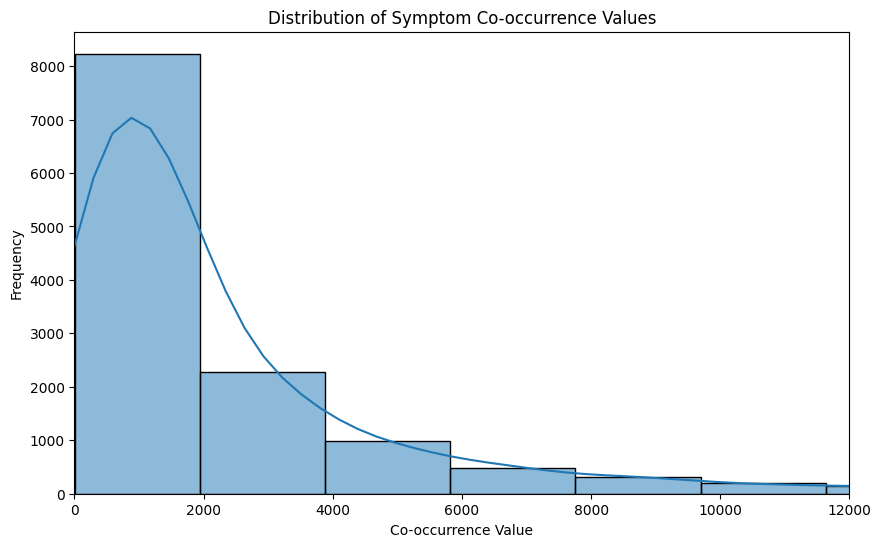

In [257]:
cooccurrence_values = []
for symptom1, connections in cooccurrence_matrix.items():
    for symptom2, weight in connections.items():
        if weight > 0:
            cooccurrence_values.append(weight)

# Convert to a Pandas Series for easier plotting
cooccurrence_series = pd.Series(cooccurrence_values)

plt.figure(figsize=(10, 6))
sns.histplot(cooccurrence_series, kde=True, bins=30)  # Adjust bins as needed
plt.xlabel('Co-occurrence Value')
plt.ylabel('Frequency')
plt.title('Distribution of Symptom Co-occurrence Values')

plt.xlim(0, 12000)

plt.show()

In [1]:
import numpy as np
plt.figure(figsize=(10, 6))
# sns.histplot(cooccurrence_series, kde=True, bins=30, log_scale=(False, True))
sns.histplot(np.log1p(cooccurrence_series), kde=True, bins=30)
plt.xlabel('Co-occurrence Value')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Symptom Co-occurrence Values')
plt.xlim(0, 50)
plt.show()

NameError: name 'plt' is not defined